In [1]:
import cptac
import cptac.utils as ut
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plot_utils as p
import warnings
#warnings.filterwarnings('ignore')

In [2]:
#import CPTAC data
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
o = cptac.Ovarian()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()
ls = cptac.Lscc()
rc = cptac.Ccrcc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


In [40]:
### unchanged 

def get_genotype_all_vars(self, mutations_genes, mutations_filter=None, show_location=True, mutation_hotspot=None):
        """Return a dataframe that has the mutation type and wheather or not it is a multiple mutation
        Parameters:
        mutation_genes (str, or list or array-like of str): The gene(s) to get mutation data for.
        mutations_filter (list, optional):  List of mutations to prioritize when filtering out multiple mutations, in order of priority.
        show_location (bool, optional): Whether to include the Location column from the mutation dataframe. Defaults to True.
        mutation_hotspot (optional): a list of hotspots
        """

        #If they don't give us a filter, this is the default.

        if mutations_filter == None:
            if self.get_cancer_type() == "colon":
                mutations_filter = ["Deletion", #deletion
                                        'frameshift deletion', 'frameshift insertion', 'frameshift substitution', 'stopgain', 'stoploss', #truncation
                                        'Missense_Mutation_hotspot',
    	                                'nonframeshift deletion', 'nonframeshift insertion', 'nonframeshift substitution', 'nonsynonymous SNV', #missense
                                        'Amplification',
                                         'Wildtype']


            elif self.get_cancer_type() == "hnscc":
                mutations_filter = ["Deletion", #deletion
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                                        'Missense_Mutation_hotspot',
    	                                'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                                        'Silent','Wildtype']

            elif self.get_cancer_type() == "gbm":
                mutations_filter = ["Deletion", #deletion
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                                        'Missense_Mutation_hotspot',
                                        'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                                        'Silent','Wildtype']

            else:
                mutations_filter = ["Deletion",
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #tuncation
                                        'Missense_Mutation_hotspot',
    	                                'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site'
                                        'Silent',
                                        'Wildtype']

        if self.get_cancer_type() == 'colon':
            truncations = ['frameshift deletion', 'frameshift insertion', 'frameshift substitution', 'stopgain', 'stoploss']
            missenses = ['nonframeshift deletion', 'nonframeshift insertion', 'nonframeshift substitution', 'nonsynonymous SNV']
        elif self.get_cancer_type() == 'hnscc' and self.version() == "0.1":
            truncations =["stopgain", "stoploss"]
            missenses = ["nonframeshift insertion", "nonframeshift deletion"]
        else:
            truncations = ['Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site']
            missenses = ['In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation']

        if self.get_cancer_type() == "gbm":
            noncodings = ["Intron", "RNA", "3'Flank", "Splice_Region", "5'UTR", "5'Flank", "3'UTR"]



        #check that gene is in the somatic_mutation DataFrame
        somatic_mutation = self.get_somatic_mutation()
        if mutations_genes not in somatic_mutation["Gene"].unique(): #if the gene isn't in the somacic mutations df it will still have CNV data that we want
            def add_del_and_amp_no_somatic(row):
                print(row['PTEN'])
                if row[mutations_genes] <= -.2:
                    mutations = 'Deletion'

                elif row[mutations_genes] >= .2:
                    mutations = 'Amplification'
                else:
                    mutations = "No_Mutation"

                return mutations


            cnv = self.get_CNV()
            gene_cnv = cnv[["PTEN"]]
            mutation_col = gene_cnv.apply(add_del_and_amp_no_somatic, axis=1)
            df = gene_cnv.assign(Mutation = mutation_col)
            return df


        #combine the cnv and mutations dataframe
        combined = self.join_omics_to_mutations(omics_df_name="CNV", mutations_genes=mutations_genes, omics_genes=mutations_genes)


        #drop the database index from ccrcc
        if self.get_cancer_type() == "ccrcc" or self.get_cancer_type() == "brca":
            cc = self.get_CNV()
            drop = ['Database_ID']
            combined = ut.reduce_multiindex(df=combined, levels_to_drop=drop)


        #If there are hotspot mutations, append 'hotspot' to the mutation type so that it's prioritized correctly
        def mark_hotspot_locations(row):
            #iterate through each location in the current row
            mutations = []
            for location in row[mutations_genes+'_Location']:
                if location in mutation_hotspot: #if it's a hotspot mutation
                    #get the position of the location
                    position = row[mutations_genes+'_Location'].index(location)
                    #use that to change the correct mutation
                    mutations.append(row[mutations_genes+"_Mutation"][position] + "_hotspot")
                else:
                    # get the position of the location
                    position = row[mutations_genes+'_Location'].index(location)
                    mutations.append(row[mutations_genes+"_Mutation"][position])
            return mutations

        if mutation_hotspot is not None:
            combined['hotspot'] = combined.apply(mark_hotspot_locations, axis=1)
            combined[mutations_genes+"_Mutation"] = combined['hotspot']
            combined = combined.drop(columns='hotspot')

        # Based on cnv make a new column with mutation type that includes deletions and amplifications
        def add_del_and_amp(row):
            if row[mutations_genes+"_CNV"] <= -.2:
                mutations = row[mutations_genes+"_Mutation"] + ['Deletion']
                locations = row[mutations_genes+'_Location']+['Deletion']

            elif row[mutations_genes+"_CNV"] >= .2:
                mutations = row[mutations_genes+"_Mutation"] + ['Amplification']
                locations = row[mutations_genes+'_Location']+['Amplification']
            else:
                mutations = row[mutations_genes+"_Mutation"]
                locations = row[mutations_genes+"_Location"]

            return mutations, locations


        combined['mutations'], combined['locations'] = zip(*combined.apply(add_del_and_amp, axis=1))


        #now that we have the deletion and amplifications, we need to prioritize the correct mutations.
        def sort(row):
            sortedcol = []
            location = []
            chosen_indices = []
            sample_mutations_list = row['mutations']
            sample_locations_list = row['locations']
            if len(sample_mutations_list) == 1: #if there's only one mutation in the list
                sortedcol.append(sample_mutations_list[0])
                location.append(sample_locations_list[0])

            else:
                for filter_val in mutations_filter: # This will start at the beginning of the filter list, thus filters earlier in the list are prioritized, like we want
                    if filter_val in sample_mutations_list:
                        chosen_indices = [index for index, value in enumerate(sample_mutations_list) if value == filter_val]
                    if len(chosen_indices) > 0: # We found at least one mutation from the filter to prioritize, so we don't need to worry about later values in the filter priority list
                        break

                if len(chosen_indices) == 0: # None of the mutations for the sample were in the filter, so we're going to have to use our default hierarchy
                    for mutation in sample_mutations_list:
                        if mutation in truncations:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                if len(chosen_indices) == 0: # None of them were in the filter, nor were truncations, so we'll grab all the missenses
                    for mutation in sample_mutations_list:
                        if mutation in missenses:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                if self.get_cancer_type() == "gbm" and len(chosen_indices) == 0: # None of them were in the filter, nor were truncations, nor missenses, so we'll grab all the noncodings
                    for mutation in sample_mutations_list:
                        if mutation in noncodings:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                soonest_mutation = sample_mutations_list[chosen_indices[0]]
                soonest_location = sample_locations_list[chosen_indices[0]]
                chosen_indices.clear()
                sortedcol.append(soonest_mutation)
                location.append(soonest_location)

            return pd.Series([sortedcol, location],index=['mutations', 'locations'])

        df = combined.apply(sort, axis=1)
        combined['Mutation'] = df['mutations']
        combined['Location'] = df['locations']

        #get a sample_status column that says if the gene has multiple mutations (including dletion and amplification)
        def sample_status(row):
            if len(row['mutations']) > 1: #if there's more than one mutation
                if len(row['mutations']) == 2 and "Wildtype_Tumor" in row['mutations']: #one of the mutations might be a "wildtype tumor"
                    status ="Single_mutation"

                elif len(row['mutations']) == 2 and "Wildtype_Normal" in row['mutations']:
                    status ="Single_mutation"

                else:
                    status = "Multiple_mutation"
            else:
                if row["mutations"] == ["Wildtype_Normal"]:
                    status = "Wildtype_Normal"
                elif row['mutations'] == ['Wildtype_Tumor']:
                    status = "Wildtype_Tumor"
                else:
                    status = "Single_mutation"

            return status
        combined['Mutation_Status'] = combined.apply(sample_status, axis=1)

        #drop all the unnecessary Columns
        df = combined.drop(columns=[mutations_genes+"_CNV", mutations_genes+"_Mutation", mutations_genes+"_Location", mutations_genes+"_Mutation_Status", 'Sample_Status', 'mutations','locations'])
        df['Mutation'] = [','.join(map(str, l)) for l in df['Mutation']]
        df['Location'] = [','.join(map(str, l)) for l in df['Location']]
        if show_location == False: df = df.drop(columns="Location") #if they don't want us to show the location, drop it
        return df

In [26]:
import pdb

In [3]:
def get_genotype_all_vars(self, mutations_genes, mutations_filter=None, show_location=True, mutation_hotspot=None):
        """Return a dataframe that has the mutation type and wheather or not it is a multiple mutation
        Parameters:
        mutation_genes (str, or list or array-like of str): The gene(s) to get mutation data for.
        mutations_filter (list, optional):  List of mutations to prioritize when filtering out multiple mutations, in order of priority.
        show_location (bool, optional): Whether to include the Location column from the mutation dataframe. Defaults to True.
        mutation_hotspot (optional): a list of hotspots
        """

        #If they don't give us a filter, this is the default.
        if mutations_filter == None:
            if self.get_cancer_type() == "colon":
                mutations_filter = ["Deletion", #deletion
                                        'frameshift deletion', 'frameshift insertion', 'frameshift substitution', 'stopgain', 'stoploss', #truncation
                                        'Missense_Mutation_hotspot',
    	                                'nonframeshift deletion', 'nonframeshift insertion', 'nonframeshift substitution', 'nonsynonymous SNV', #missense
                                        'Amplification',
                                         'Wildtype']


            elif self.get_cancer_type() == "hnscc":
                mutations_filter = ["Deletion", #deletion
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                                        'Missense_Mutation_hotspot',
    	                                'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                                        'Silent','Wildtype']

            elif self.get_cancer_type() == "gbm":
                mutations_filter = ["Deletion", #deletion
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                                        'Missense_Mutation_hotspot',
                                        'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                                        'Silent','Wildtype']

            else:
                mutations_filter = ["Deletion",
                                        'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #tuncation
                                        'Missense_Mutation_hotspot',
    	                                'Missense_Mutation',
                                        'Amplification',
                                        'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site'
                                        'Silent',
                                        'Wildtype']

        if self.get_cancer_type() == 'colon':
            truncations = ['frameshift deletion', 'frameshift insertion', 'frameshift substitution', 'stopgain', 'stoploss']
            missenses = ['nonframeshift deletion', 'nonframeshift insertion', 'nonframeshift substitution', 'nonsynonymous SNV']
        elif self.get_cancer_type() == 'hnscc' and self.version() == "0.1":
            truncations =["stopgain", "stoploss"]
            missenses = ["nonframeshift insertion", "nonframeshift deletion"]
        else:
            truncations = ['Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site']
            missenses = ['In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation']

        if self.get_cancer_type() == "gbm":
            noncodings = ["Intron", "RNA", "3'Flank", "Splice_Region", "5'UTR", "5'Flank", "3'UTR"]



        #check that gene is in the somatic_mutation DataFrame
        somatic_mutation = self.get_somatic_mutation()
        if mutations_genes not in somatic_mutation["Gene"].unique(): #if the gene isn't in the somacic mutations df it will still have CNV data that we want
            def add_del_and_amp_no_somatic(row):
                if row[mutations_genes] <= -.2:
                    mutations = 'Deletion'
                elif row[mutations_genes] >= .2:
                    mutations = 'Amplification'
                else:
                    mutations = "No_Mutation" 
                    
                return mutations


            cnv = self.get_CNV()
            
            #drop the database index from ccrcc and brca
            if isinstance(cnv.keys(), pd.core.indexes.multi.MultiIndex): ##
                drop = ['Database_ID']
                cnv = ut.reduce_multiindex(df=cnv, levels_to_drop=drop)
                
            gene_cnv = cnv[[mutations_genes]] ##
            mutation_col = gene_cnv.apply(add_del_and_amp_no_somatic, axis=1)
            df = gene_cnv.assign(Mutation = mutation_col)
            return df


        #combine the cnv and mutations dataframe
        combined = self.join_omics_to_mutations(omics_df_name="CNV", mutations_genes=mutations_genes, omics_genes=mutations_genes)


        #drop the database index from ccrcc
        if self.get_cancer_type() == "ccrcc" or self.get_cancer_type() == "brca":
            cc = self.get_CNV()
            drop = ['Database_ID']
            combined = ut.reduce_multiindex(df=combined, levels_to_drop=drop)


        #If there are hotspot mutations, append 'hotspot' to the mutation type so that it's prioritized correctly
        def mark_hotspot_locations(row):
            #iterate through each location in the current row
            mutations = []
            for location in row[mutations_genes+'_Location']:
                if location in mutation_hotspot: #if it's a hotspot mutation
                    #get the position of the location
                    position = row[mutations_genes+'_Location'].index(location)
                    #use that to change the correct mutation
                    mutations.append(row[mutations_genes+"_Mutation"][position] + "_hotspot")
                else:
                    # get the position of the location
                    position = row[mutations_genes+'_Location'].index(location)
                    mutations.append(row[mutations_genes+"_Mutation"][position])
            return mutations

        if mutation_hotspot is not None:
            combined['hotspot'] = combined.apply(mark_hotspot_locations, axis=1)
            combined[mutations_genes+"_Mutation"] = combined['hotspot']
            combined = combined.drop(columns='hotspot')

        # Based on cnv make a new column with mutation type that includes deletions and amplifications
        def add_del_and_amp(row):
            if row[mutations_genes+"_CNV"] <= -.2:
                mutations = row[mutations_genes+"_Mutation"] + ['Deletion']
                locations = row[mutations_genes+'_Location']+['Deletion']

            elif row[mutations_genes+"_CNV"] >= .2:
                mutations = row[mutations_genes+"_Mutation"] + ['Amplification']
                locations = row[mutations_genes+'_Location']+['Amplification']
            else:
                mutations = row[mutations_genes+"_Mutation"]
                locations = row[mutations_genes+"_Location"]

            return mutations, locations


        combined['mutations'], combined['locations'] = zip(*combined.apply(add_del_and_amp, axis=1))


        #now that we have the deletion and amplifications, we need to prioritize the correct mutations.
        def sort(row):
            sortedcol = []
            location = []
            chosen_indices = []
            sample_mutations_list = row['mutations']
            sample_locations_list = row['locations']
            if len(sample_mutations_list) == 1: #if there's only one mutation in the list
                sortedcol.append(sample_mutations_list[0])
                location.append(sample_locations_list[0])

            else:
                for filter_val in mutations_filter: # This will start at the beginning of the filter list, thus filters earlier in the list are prioritized, like we want
                    if filter_val in sample_mutations_list:
                        chosen_indices = [index for index, value in enumerate(sample_mutations_list) if value == filter_val]
                    if len(chosen_indices) > 0: # We found at least one mutation from the filter to prioritize, so we don't need to worry about later values in the filter priority list
                        break

                if len(chosen_indices) == 0: # None of the mutations for the sample were in the filter, so we're going to have to use our default hierarchy
                    for mutation in sample_mutations_list:
                        if mutation in truncations:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                if len(chosen_indices) == 0: # None of them were in the filter, nor were truncations, so we'll grab all the missenses
                    for mutation in sample_mutations_list:
                        if mutation in missenses:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                if self.get_cancer_type() == "gbm" and len(chosen_indices) == 0: # None of them were in the filter, nor were truncations, nor missenses, so we'll grab all the noncodings
                    for mutation in sample_mutations_list:
                        if mutation in noncodings:
                            chosen_indices += [index for index, value in enumerate(sample_mutations_list) if value == mutation]

                soonest_mutation = sample_mutations_list[chosen_indices[0]]
                soonest_location = sample_locations_list[chosen_indices[0]]
                chosen_indices.clear()
                sortedcol.append(soonest_mutation)
                location.append(soonest_location)

            return pd.Series([sortedcol, location],index=['mutations', 'locations'])

        df = combined.apply(sort, axis=1)
        combined['Mutation'] = df['mutations']
        combined['Location'] = df['locations']

        #get a sample_status column that says if the gene has multiple mutations (including dletion and amplification)
        def sample_status(row):
            if len(row['mutations']) > 1: #if there's more than one mutation
                if len(row['mutations']) == 2 and "Wildtype_Tumor" in row['mutations']: #one of the mutations might be a "wildtype tumor"
                    status ="Single_mutation"

                elif len(row['mutations']) == 2 and "Wildtype_Normal" in row['mutations']:
                    status ="Single_mutation"

                else:
                    status = "Multiple_mutation"
            else:
                if row["mutations"] == ["Wildtype_Normal"]:
                    status = "Wildtype_Normal"
                elif row['mutations'] == ['Wildtype_Tumor']:
                    status = "Wildtype_Tumor"
                else:
                    status = "Single_mutation"

            return status
        combined['Mutation_Status'] = combined.apply(sample_status, axis=1)

        #drop all the unnecessary Columns
        df = combined.drop(columns=[mutations_genes+"_CNV", mutations_genes+"_Mutation", mutations_genes+"_Location", mutations_genes+"_Mutation_Status", 'Sample_Status', 'mutations','locations'])
        df['Mutation'] = [','.join(map(str, l)) for l in df['Mutation']]
        df['Location'] = [','.join(map(str, l)) for l in df['Location']]
        if show_location == False: df = df.drop(columns="Location") #if they don't want us to show the location, drop it
        return df


In [4]:
# follow this order (for plot) #gbm, hnscc, rcc
#['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"
ca_obj = {'Endometrial':en, 'Glioblastoma':g, 'Head and Neck':hn, 'Ovarian':o, 'Renal':rc, 'Colon':col, 'Lung Adenocarcinoma':l,'Breast':b, 'Lung Squamous':ls}

In [5]:
for cancer in ca_obj:
    print(cancer)
    ca = ca_obj[cancer]
    mut = get_genotype_all_vars(ca, 'KRAS')
    print(mut.Mutation.value_counts(), '\n')

Endometrial
Wildtype_Tumor       60
Missense_Mutation    31
Amplification         3
Deletion              1
Name: Mutation, dtype: int64 

Glioblastoma
No_Mutation      93
Amplification     3
Deletion          2
Name: Mutation, dtype: int64 

Head and Neck
No_Mutation      84
Amplification    20
Deletion          5
Name: Mutation, dtype: int64 

Ovarian


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 92)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, li

Wildtype_Tumor       51
Amplification        37
Deletion             12
Missense_Mutation     2
Name: Mutation, dtype: int64 

Renal
No_Mutation      97
Amplification    13
Name: Mutation, dtype: int64 

Colon
Wildtype_Tumor       57
nonsynonymous SNV    32
Deletion             10
Amplification         7
Name: Mutation, dtype: int64 

Lung Adenocarcinoma


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 71 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 92)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 92)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 76 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 92)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 121 s

Wildtype_Tumor       57
Missense_Mutation    28
Deletion             14
Amplification        10
Name: Mutation, dtype: int64 

Breast
Wildtype_Tumor       91
Amplification        21
Deletion              9
Missense_Mutation     1
Name: Mutation, dtype: int64 

Lung Squamous
Wildtype_Tumor       57
Amplification        43
Missense_Mutation     5
Deletion              3
Name: Mutation, dtype: int64 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 103 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 92)


In [7]:
# follow this order (for plot) #gbm, hnscc, rcc
#['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"
ca_obj = {'Endometrial':en}#, 'Glioblastoma':g, 'Head and Neck':hn, 'Ovarian':o, 'Renal':rc, 'Colon':col, 'Lung Adenocarcinoma':l,'Breast':b, 'Lung Squamous':ls}

In [ ]:
'''["Deletion", #deletion
                            'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                            'Missense_Mutation_hotspot',
                            'Missense_Mutation',
                            'Amplification',
                            'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                            'Silent','Wildtype']'''

In [32]:

if ca.get_cancer_type() == "colon":
    mutations_filter = ['frameshift deletion', 'frameshift insertion', 'frameshift substitution', 'stopgain', 'stoploss', #truncation
                            'nonframeshift deletion', 'nonframeshift insertion', 'nonframeshift substitution', 'nonsynonymous SNV', #missense
                             'Wildtype']


elif ca.get_cancer_type() == "hnscc":
    mutations_filter = ["Deletion", #deletion
                            'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                            'Missense_Mutation_hotspot',
                            'Missense_Mutation',
                            'Amplification',
                            'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                            'Silent','Wildtype']

elif ca.get_cancer_type() == "gbm":
    mutations_filter = ["Deletion", #deletion
                            'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #truncation
                            'Missense_Mutation_hotspot',
                            'Missense_Mutation',
                            'Amplification',
                            'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site' #inframe changes
                            'Silent','Wildtype']

elif ca.get_cancer_type() == 'endometrial':
    mutations_filter = ['Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #tuncation
                            'Missense_Mutation',
                            'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site']
                            
                            
    
else:
    mutations_filter = ['Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Nonstop_Mutation', #tuncation
                            'Missense_Mutation',
                            'In_Frame_Del', 'In_Frame_Ins', 'Splice_Site'
                            'Silent',
                            'Wildtype']


In [57]:
gene = 'KRAS'

for cancer in ca_obj:
    print(cancer)
    ca = ca_obj[cancer]
    cnv = ca.get_CNV()
    gene_df = cnv[[gene]]
    del_df = gene_df.loc[gene_df['KRAS'] < -0.2]
    amp_df = gene_df.loc[gene_df['KRAS'] > 0.2]
    print('deletion:', len(del_df))
    print('amplification:', len(amp_df))
    
    mut = ca.join_omics_to_mutations(omics_df_name="CNV", mutations_genes=gene, omics_genes=gene, 
                                     mutations_filter =mutations_filter, tissue_type= 'tumor')
    print(mut[gene+'_Mutation'].value_counts(), '\n')
    print('total samples with values:', len(mut), '\n')
    
    # Find overlapping IDs
    amp_ID = list(amp_df.index)
    del_ID = list(del_df.index)
    cnv_ID = amp_ID + del_ID
    other_mut_ID = list(mut.loc[mut[gene+'_Mutation'] != 'Wildtype_Tumor'].index)
    
    if len(other_mut_ID) > len(cnv_ID):
        both_lists = [element for element in other_mut_ID if element in cnv_ID]
    else:
        both_lists = [element for element in cnv_ID if element in other_mut_ID]
        
    amp_overlap = [element for element in amp_ID if element in other_mut_ID]
    print('num amp overlap:', len(amp_overlap))
    amp = mut[mut.index.isin(amp_overlap)]
    print(amp)
    
    print(len(both_lists))

Endometrial
deletion: 1
amplification: 6
Wildtype_Tumor       64
Missense_Mutation    31
Name: KRAS_Mutation, dtype: int64 

total samples with values: 95 

num amp overlap: 4
Name        KRAS_CNV      KRAS_Mutation KRAS_Location KRAS_Mutation_Status  \
Patient_ID                                                                   
C3L-00362       0.41  Missense_Mutation        p.G12C      Single_mutation   
C3L-00780       0.21  Missense_Mutation        p.G12V      Single_mutation   
C3N-00848       0.24  Missense_Mutation        p.G13D      Single_mutation   
C3N-01003       0.34  Missense_Mutation        p.G12V      Single_mutation   

Name       Sample_Status  
Patient_ID                
C3L-00362          Tumor  
C3L-00780          Tumor  
C3N-00848          Tumor  
C3N-01003          Tumor  
4


cptac warning: Filter value Frame_Shift_Del does not exist in the mutations data for the KRAS gene, though it exists for other genes. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 14)
cptac warning: Filter value Frame_Shift_Ins does not exist in the mutations data for the KRAS gene, though it exists for other genes. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 14)
cptac warning: Filter value Nonsense_Mutation does not exist in the mutations data for the KRAS gene, though it exists for other genes. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 14)
cptac warning: Filter value Nonstop_Mutation does not exist in the mutations data for the KRAS gene, though it exists for other genes. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 14)
cptac warning: Filter value In_Frame_Del does not

In [14]:
gene = 'KRAS'
cnv = ca.get_CNV()
gene_df = cnv[[gene]]
del_df = gene_df.loc[gene_df['KRAS'] < 0.2]
len(del_df)

88

In [ ]:
# follow this order (for plot) #gbm, hnscc, rcc
#['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"
ca_obj = {'Endometrial':en, 'Glioblastoma':g, 'Head and Neck':hn, 'Ovarian':o, 'Renal':rc, 'Colon':col, 'Lung Adenocarcinoma':l,'Breast':b, 'Lung Squamous':ls}

In [21]:
# # gbm, hnscc, ccrcc, 
gg = get_genotype_all_vars(g, 'EGFR')

EGFR


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the EGFR gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 98)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 98)


In [22]:
#gg.loc[gg['KRAS'] > 0.2]
gg.Mutation.value_counts()

Amplification        66
Wildtype_Tumor       17
Missense_Mutation    16
Name: Mutation, dtype: int64

In [54]:
ca = rc
cnv = ca.get_CNV()
cnv['KRAS']

Database_ID,ENSG00000133703.11
Patient_ID,
C3L-00004,0.015820
C3L-00010,0.019790
C3L-00011,0.134582
C3L-00026,-0.021377
C3L-00079,-0.183039
...,...
C3N-01646,0.063777
C3N-01648,-0.012302
C3N-01649,0.026971


In [62]:
mut = ca.get_somatic_mutation()
mut.loc[mut['Gene'] == 'KRAS']

Name,Gene,Mutation,Location
Patient_ID,,,


In [4]:
def mult_mutations(mut, list_in):
    if list_in.count(mut) > 1:
        name = mut
    while mut in list_in: list_in.remove(mut)
    
    for e in list_in:
        name = e+', '+name
        
    name_list = name.split(', ') # return to list in case there are more multiple mutations
    return name_list
    

In [5]:
def find_multi_cis_mut(cancer_obj, cis_gene):
    #Get all somatic mutations 
    mutations = cancer_obj.get_somatic_mutation()
    #get just somatic mutations for cis_gene
    cis_mut = mutations[mutations.Gene == cis_gene]
    cis_mut = cis_mut[["Mutation"]]
    
    #simplfy names 
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Del', 'Missense', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Ins', 'Missense', inplace = True)

    # replace colon different mutation names
    colon_mut_names = {'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
                   'frameshift substitution': 'Truncation', 'stopgain': 'Truncation', 'stoploss': 'Truncation',
                  'nonframeshift deletion': 'Missense', 'nonframeshift insertion': 'Missense', 
                   'nonframeshift substitution': 'Missense', 'nonsynonymous SNV': 'Missense'}
    cis_mut = cis_mut.replace(colon_mut_names)
    
    #group Truncation
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)
    
    
    # Multiple somatic mutations are indicated using multiple rows with the same patient ids.
    # We will group the rows by patient ids and then relabel the columns that have multiple mutations 
    cis_mut = cis_mut.groupby(level=['Patient_ID'], sort=False).agg( ','.join)
    
    # Create multiple mutation label for each multiple mutation in a sample
    cis_mut = cis_mut[['Mutation']].apply(lambda x: x.str.split(',')) # put in list to use mult_mutations function
    possible_mutations = ['Truncation', 'Missense', 'Indel', 'Splice_Site']
    for mut in possible_mutations:
        cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: mult_mutations(mut, x) if x.count(mut) > 1 else x)
    # change list to string
    delim = ', '
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: delim.join(x) if type(x) is list else x)

    #get CNV mutations 
    mut_copy_num = cancer_obj.get_genotype_all_vars(cis_gene, mutations_filter = ["Deletion","Amplification","Wildtype_Tumor"])
    mut_copy_num["Mutation"].where(mut_copy_num['Mutation'] != 'No_Mutation', 'Wildtype_Tumor', inplace = True) # change No_Mutation to Wildtype_Tumor
    mut_copy_num = mut_copy_num[mut_copy_num['Mutation'].isin(["Deletion","Amplification","Wildtype_Tumor"])]
    mut_copy_num = mut_copy_num.rename(columns={'Mutation': 'CNV_Mutation'})
    mut_copy_num = mut_copy_num["CNV_Mutation"]
    mutations = pd.merge(mut_copy_num, cis_mut, on="Patient_ID", how = "outer")
    
    # If mutation column is NaN replace with value in Mutation_Copy_Num
    mutations['Mutation'] = mutations.apply(
        lambda row: row['CNV_Mutation'] if pd.isnull(row['Mutation']) else row['Mutation'], axis=1)
   # mutations = mutations.CNV_Mutation.fillna('', inplace=True)
    #Make column All_Mutation which is a list of all mutations 
    mutations = mutations.replace(np.nan, '', regex=True)
    mutations['All_Mutations'] = mutations.apply(
        lambda row: row["CNV_Mutation"] + ", Other_Mutation" if (row["CNV_Mutation"] != row["Mutation"] and row["CNV_Mutation"] != "") else row['Mutation'], axis=1)
    mutations = mutations.rename(columns={'All_Mutations': 'All_Mutations_' + cis_gene})
    
       
    return mutations

In [ ]:
# gbm, hnscc, ccrcc, 

In [19]:
# follow this order (for plot) #gbm, hnscc, rcc
#['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"
caob = {'Endometrial':en, 'Ovarian':o, 'Colon':col, 'Lung Adenocarcinoma':l,'Breast':b, 'Lung Squamous':ls}

In [24]:
cis_gene = 'PTEN'
other_gene = 'KRAS'

dfs = {}
df_names = []
df_list = []

for cancer in caob:
    ca = caob[cancer]
    
    cis_df = find_multi_cis_mut(ca, 'PTEN')
   
    cis_df = cis_df[['All_Mutations_'+cis_gene]]
    
    del_df = cis_df.loc[cis_df['All_Mutations_'+cis_gene].str.contains('Deletion')]
    del_list = list(del_df['All_Mutations_'+cis_gene].unique())
    del_df = del_df.where(del_df == 'Deletion', cis_gene+'_Deletion') # when not del only, replace
    del_df = del_df.where(del_df != 'Deletion', cis_gene+'_Deletion')
    
    other_wt = cis_df.loc[~ cis_df['All_Mutations_'+cis_gene].isin(del_list)]
    #print(other_wt['All_Mutations_'+cis_gene].unique())
    other_wt = other_wt.where(other_wt == 'Wildtype_Tumor', cis_gene+'_Other_Mutation')
    other_wt = other_wt.where(other_wt != 'Wildtype_Tumor', cis_gene+'_Wildtype')
    
    cis_mut = other_wt.append(del_df)
    #print(cis_mut['All_Mutations_'+cis_gene].value_counts())
    
    # Other gene col
    other_df = find_multi_cis_mut(ca, other_gene)
    other_mut = other_df[['All_Mutations_'+other_gene]]
    other_mut = other_mut.where(other_mut == 'Wildtype_Tumor', other_gene+'_Mutated')
    other_mut = other_mut.where(other_mut != 'Wildtype_Tumor', other_gene+'_Wildtype')
    
    # Join cols
    all_df = cis_mut.join(other_mut, how = 'outer')
    all_df['all'] = all_df['All_Mutations_'+cis_gene] + ', '+ all_df['All_Mutations_'+other_gene]
    
    other_gene_list = ['_Wildtype', '_Mutated']
    for status in other_gene_list:
        all_df = all_df.where(all_df != 'PTEN_Other_Mutation, '+other_gene+status, cis_gene+'_Other_Mutation')
        all_df = all_df.where(all_df != 'PTEN_Wildtype, '+other_gene+status, cis_gene+'_Wildtype')
    
    print(cancer, len(all_df))
    print(all_df['all'].value_counts(), '\n')
    
    dfs[cancer] = all_df
    df_names.append(cancer)
    df_list.append(all_df[['all']].dropna())

Endometrial 95
PTEN_Other_Mutation             77
PTEN_Wildtype                   15
PTEN_Deletion, KRAS_Wildtype     2
PTEN_Deletion, KRAS_Mutated      1
Name: all, dtype: int64 

Ovarian 102
PTEN_Wildtype                   57
PTEN_Other_Mutation             19
PTEN_Deletion, KRAS_Mutated     14
PTEN_Deletion, KRAS_Wildtype    12
Name: all, dtype: int64 

Colon 106
PTEN_Wildtype                   76
PTEN_Deletion, KRAS_Mutated     17
PTEN_Deletion, KRAS_Wildtype     8
PTEN_Other_Mutation              5
Name: all, dtype: int64 

Lung Adenocarcinoma 109
PTEN_Wildtype                   88
PTEN_Deletion, KRAS_Mutated      9
PTEN_Deletion, KRAS_Wildtype     8
PTEN_Other_Mutation              4
Name: all, dtype: int64 

Breast 122
PTEN_Wildtype                   80
PTEN_Other_Mutation             18
PTEN_Deletion, KRAS_Wildtype    15
PTEN_Deletion, KRAS_Mutated      9
Name: all, dtype: int64 

Lung Squamous 108
PTEN_Wildtype                   58
PTEN_Deletion, KRAS_Mutated     23
PTEN_Delet

In [12]:
mut_copy_num = g.get_genotype_all_vars('KRAS', mutations_filter = ["Deletion","Amplification","Wildtype_Tumor"])
#TT = g.get_CNV()

#TT[['KRAS']]

KeyError: 'KRAS'

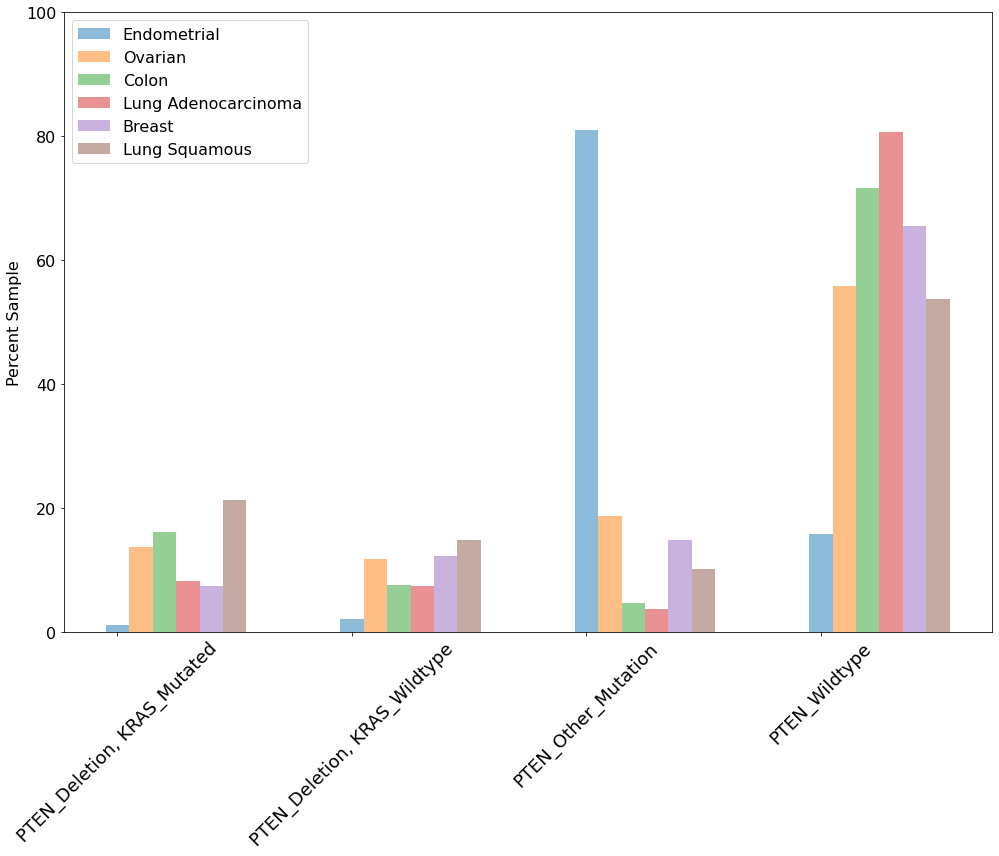

In [25]:
figure1_plot_mutations("all",df_list, df_names, save_to_path = cis_gene+'_'+other_gene+".png")

When a sample has multiple truncations, we catagorized them under truncation.